### 数据清洗与机器学习综合案例
#### 数据清洗，特征工程，缺失值填补，分类
##### 导入标准库

In [18]:
## 系统库，随机库，时间库，爬虫库，数学库
import io , os , sys , types , time , datetime , math , requests , subprocess , tempfile ,random

##### 导入三方库

In [19]:
# 数据处理
import numpy as np  # 数据处理
import pandas as pd # 数据清洗

# 数据可视化
import matplotlib.pylab as plt
# pip install missingno -i https://pypi.douban.com/simple/
import missingno
import seaborn as sns
# from pandas.tools.plotting import scatter_matrix
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

# 特征选择和编码
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,label_binarize

# 机器学习
import sklearn.ensemble as ske
from sklearn import datasets,model_selection,tree,preprocessing,metrics,linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,Lasso,SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# 网格搜索、随机搜索
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# 模型度量（分类）
from sklearn.metrics import precision_recall_fscore_support,roc_curve,auc

# 警告处理
import warnings
warnings.filterwarnings("ignore")

# 在jupyter上画图
%matplotlib inline

#### 列出所有已安装的包
##### 检查需要的包是否存在（可省略）

In [20]:
# 把conda里的包全部列举出来，并读取到pandas里
conda_packages_list = io.BytesIO(subprocess.Popen(['conda','list']
                                                  ,stdout = subprocess.PIPE).communicate()[0])
conda_packages_list = pd.read_csv(conda_packages_list
                                 ,names = ['Package Name','Version','Python Version','Repo','Other']
                                 ,delim_whitespace = True
                                 ,engine = 'python'
                                 ,skiprows = 3)
# conda_packages_list.head(50)

##### 目标
使用美国人口普查收入数据，预测个人收入是否超过每年50000美元  
数据集地址：htpps://archive.ics.uci.edu/ml/datasets/adult
##### 数据下载
注意：下载一次，然后将代码注释掉以便后续运行。数据分为训练集和测试集，将两个进行联合数据分析，然后再运行算法之前再将他们分开。


In [21]:
# 下载
DATASET = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "http://archive.ics.uci.edu/ml/machine-learning-datasets/adult/adult.names",
    "http://archive.ics.uci.edu/ml/machine-learning-datasets/adult/adult.test"
)
def download_data(path = "dataset",urls = DATASET):
    if not os.path.exists(path):
        os.mkdir(path)
    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path,name),'wb+') as f:
            f.write(response.content)
        print("-----------",str(urls.index(url)))
# 函数运行之后要注释掉，防止二次下载
# download_data()

In [22]:
# 加载训练集和测试集
# 字段名
headers = [
    "age"
    ,"workclass"
    ,"fnlwgt"
    ,"education"
    ,"education-num"
    ,"marital-status"
    ,"occupation"
    ,"relationship"
    ,"race"
    ,"sex"
    ,"capital-gain"
    ,"capital-loss"
    ,"hours-per-week"
    ,"native-country"
    ,"predclass"
]
# 加载训练集
# 读数据时，如何处理缺失值
training_raw = pd.read_csv("dataset/adult.data"
                          ,header=None
                          ,names=headers
                          ,sep = ',\s'
                          ,na_values=["?"]  #处理缺失值的方法，在本数据集中将所有的“？”设置为空
                          ,engine='python')
# 加载测试集
test_raw = pd.read_csv("dataset/adult.test"
                          ,header=None
                        ,names=headers
                        ,sep = ',\s'
                        ,na_values=["?"]
                        ,engine='python'
                       ,skiprows=1
                      )
test_raw.shape

(16281, 15)

In [23]:
# 训练集和测试集加到一起做分析
dataset_raw = training_raw.append(test_raw)
dataset_raw.reset_index(inplace = True)
dataset_raw.drop("index",inplace = True,axis = 1)

In [24]:
# 计算整个数据集占了多大内存；如果数据过大不太适合放在内存里处理，也就是不太适合pandas，例如几十个G，现在的电脑会”炸“的~
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("Bytes","KB","MB","GB","TB","PB","EB","ZB","YB")
    i = int(math.floor(math.log(size_bytes,1024)))
    p = math.pow(1024,i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s,size_name[i])
convert_size(dataset_raw.memory_usage().sum())

'5.59 MB'

#### 单一变量数据分析
特征类型  

    1. 数字型：可计算
    2. 标量型：任何包含类别或文本的特征
    

In [25]:
# 显示所有数字型特征
# dataset_raw.describe()

In [26]:
# 显示所有标量型特征
# dataset_raw.describe(include=[np.object])

In [27]:
# 查看前五行
# dataset_raw.head()

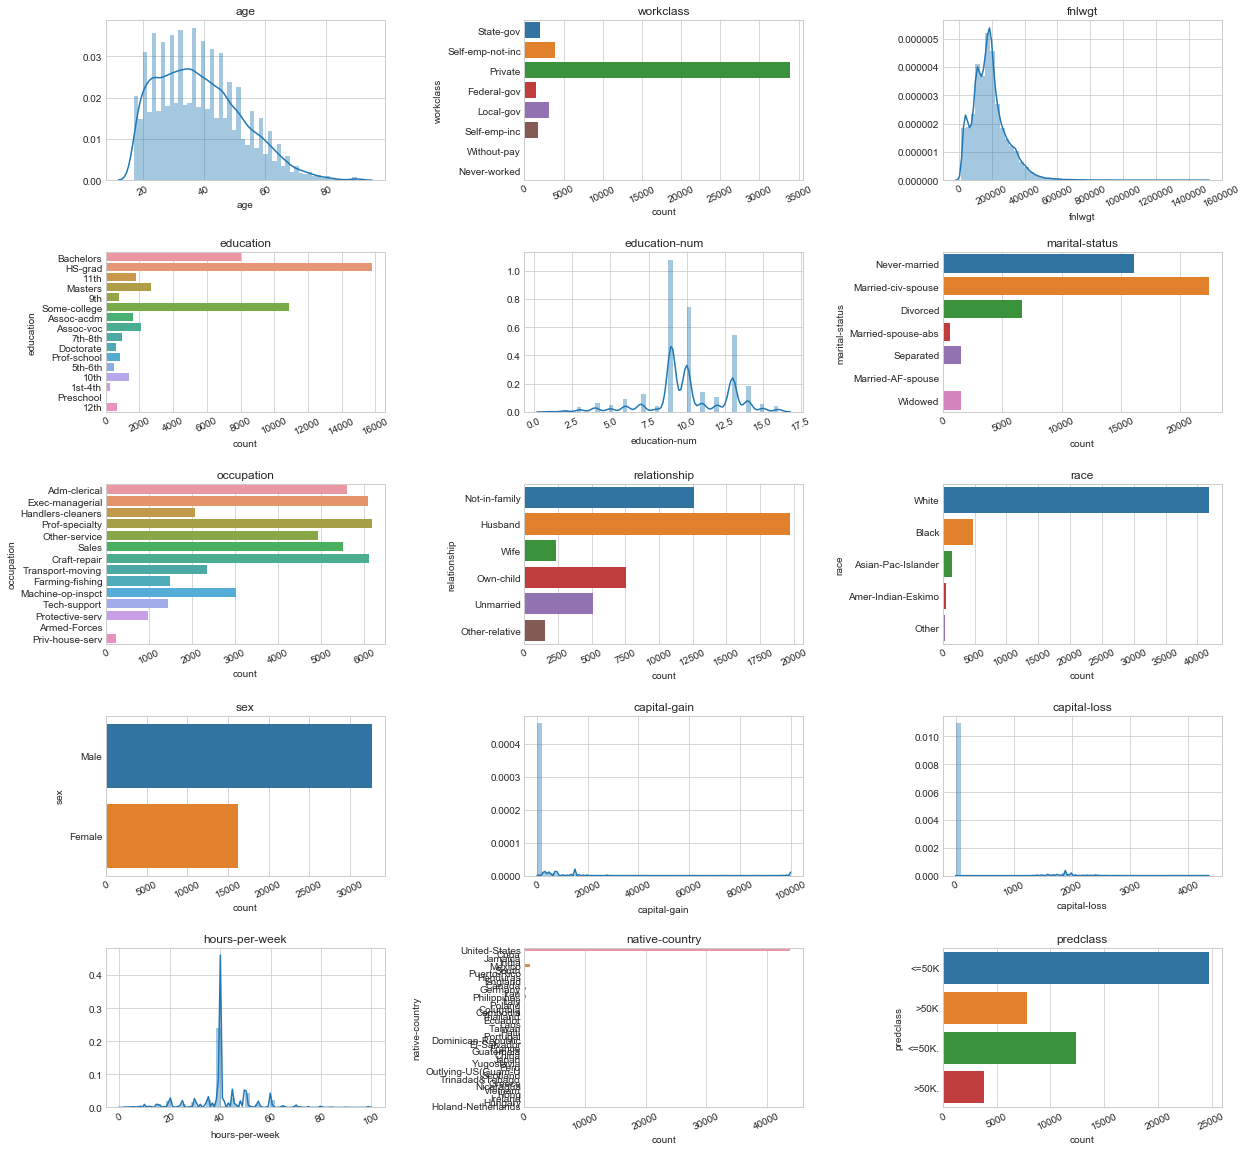

In [28]:
# 绘制每个特征的分布
def plot_distribution(dataset, cols = 5,width = 20,height = 15,hspace = 0.2 , wspace = 0.5):
    """数据集，列数，图形宽度，高度和间隔"""
    plt.style.use('seaborn-whitegrid') # seaborn画图比较好看
    fig = plt.figure(figsize=(width,height)) # 设置图形大小
    fig.subplots_adjust(left = None,bottom = None,right = None,top = None,wspace=wspace,hspace=hspace) #添加子图
    rows = math.ceil(float(dataset.shape[1] / cols))
    
    for i ,column in enumerate(dataset.columns): #取出每一个特征用来画图，若是连续性数据则绘制走势图，离散型绘制直方图
        ax = fig.add_subplot(rows,cols,i + 1)
        ax.set_title(column)
        
        if dataset.dtypes[column] == np.object: # 判断数据类型，是否是一个对象
            g = sns.countplot(y = column,data = dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels = substrings)
            plt.xticks(rotation = 25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation = 25)
plot_distribution(dataset_raw,cols=3,width = 20,height=20,hspace=0.45,wspace=0.5)

# 绘图的好处是可以对每一个特征的数据分布信息加以掌握

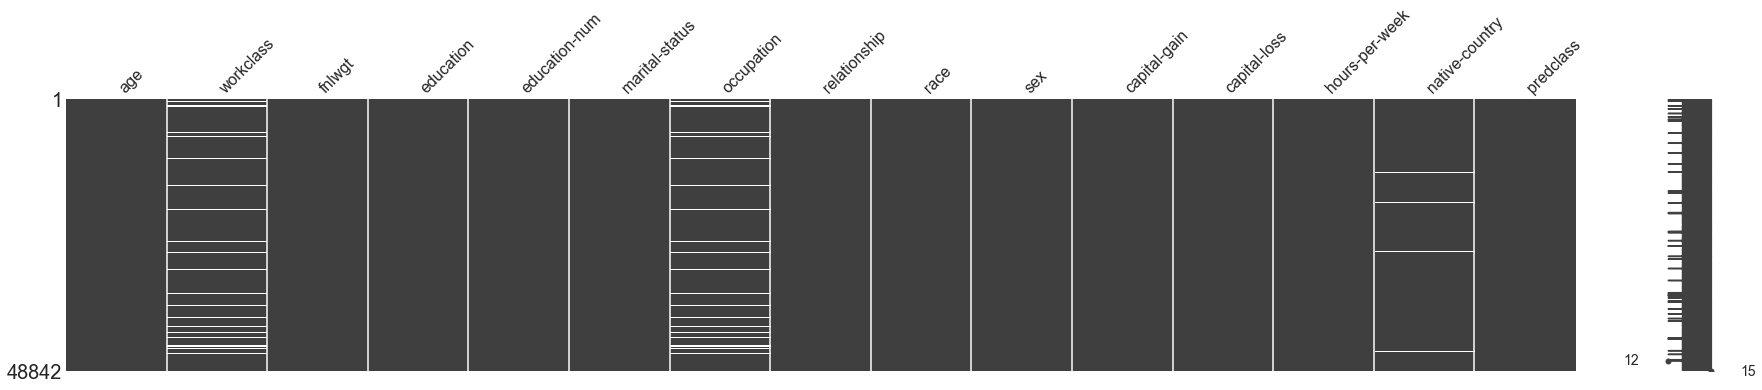

In [29]:
# 画出图形后，查看缺失值到底缺了多少
missingno.matrix(dataset_raw,figsize=(30,5))
# 凡是有白线的都是缺失值

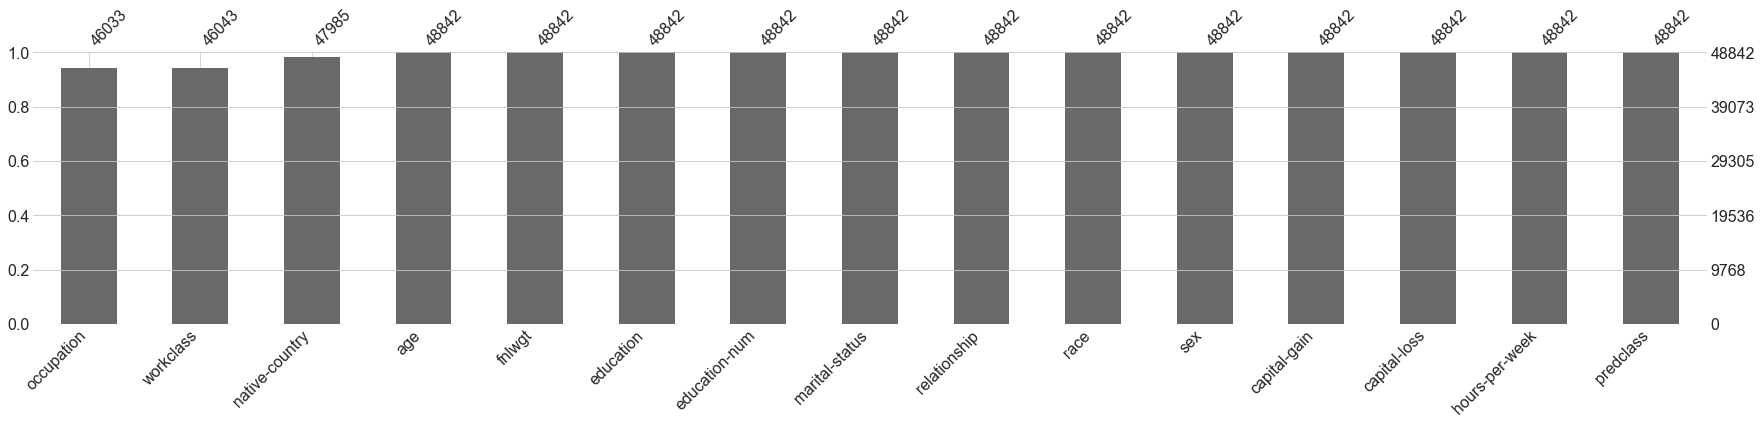

In [30]:
# 柱状图排序显示缺失值
missingno.bar(dataset_raw,sort = 'ascending',figsize = (30,5))

#### 特征清洗、特征工程、缺失值填补
**清洗：清洗什么？**
    
    缺失值：去除OR填补
    特殊值：N±lnf，NA and NaN
    奇异值：要先检测，再决定是否去除
    不一致性：年龄 < 0，男的怀孕等等
**工程：方法**
    
    分解：将2020-05-23T17：30转化为分类属性，如hour_of_the_day , part_of_day等
    离散化：连续变量离散化，比较算法再连续数据和离散数据上的不同表现，一些约定：
        dataset_bin => 连续变量离散化后
        dataset_con => 连续变量未离散化
    数值量级的转化：克 -- 千克，减少了数据细节可能会增加效率
    特征交叉：字段衍生：新字段包好许多别的字段的特征（数字or标量）
**缺失值填补：方式**
    
    均值
    中位数
    众数
    回归拟合：但是若其他特征对此没有相关性，使用了没什么实际意义
    
检查到缺失值就要对其处理，对缺失值的处理要考虑到缺失值所占的比例

In [31]:
# 创建新的DataFrame
dataset_bin = pd.DataFrame() # 包含所有离散化的值
dataset_con = pd.DataFrame() # 包含所有未离散化的值

**一个个看特征**  
**属性：predclass**  
预测目标，转换为：0/1，年收入超过50k的为1


In [32]:
# 转换
dataset_raw.loc[dataset_raw['predclass'] == ">50K","predclass"] = 1
dataset_raw.loc[dataset_raw['predclass'] == ">50K.","predclass"] = 1
dataset_raw.loc[dataset_raw['predclass'] == "<=50K","predclass"] = 0
dataset_raw.loc[dataset_raw['predclass'] == "<=50K.","predclass"] = 0
# 在训练样本里标签是不带点的，但是在测试样本里是由点的，而上面已经把训练样本和测试样本合并了，因此需要考虑到这一点

dataset_bin['predclass'] = dataset_raw['predclass']
dataset_con['predclass'] = dataset_raw['predclass']

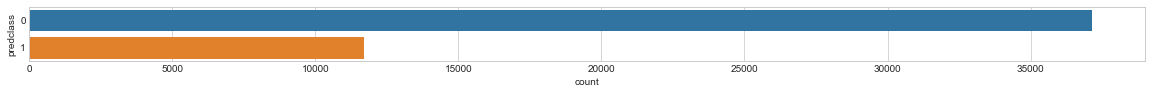

In [33]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure(figsize = (20,1))
sns.countplot(y = "predclass",data = dataset_bin)

In [34]:
# 样本本身不太均匀，用逻辑回归的效果不太好

**属性：Age**  
将使用Pandas Cut功能将数据分成大小相同的箱。原始数据放到dataset_con中  
一般对年龄进行离散化，小于和大于一定年龄可以单独并为一组，而中间分布的可以划分的更细致些  
**卡方分箱**



In [35]:
dataset_bin['age'] = pd.cut(dataset_raw['age'],10) # 平均离散化，分成10块

dataset_con['age'] = dataset_raw['age'] # 未离散化
dataset_bin.head(11)
# 但是此类分箱是不合适的

,predclass,age
0,0,"(38.9, 46.2]"
1,0,"(46.2, 53.5]"
2,0,"(31.6, 38.9]"
3,0,"(46.2, 53.5]"
4,0,"(24.3, 31.6]"
5,0,"(31.6, 38.9]"
6,0,"(46.2, 53.5]"
7,1,"(46.2, 53.5]"
8,1,"(24.3, 31.6]"
9,1,"(38.9, 46.2]"


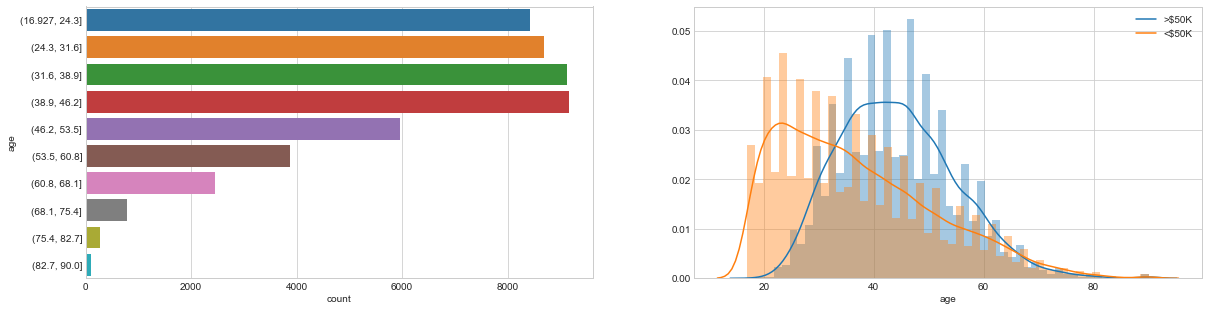

In [36]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure(figsize=(20,5))
plt.subplot(121)
sns.countplot(y = "age",data=dataset_bin)
plt.subplot(122)

# 带趋势的直方图
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age'],kde_kws={'label':'>$50K'});
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age'],kde_kws={'label':'<$50K'});

**Workclass**

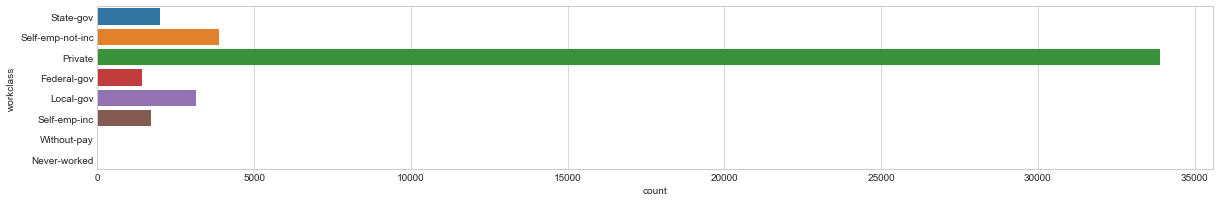

In [37]:
# 如何处理
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(20,3))
sns.countplot(y = "workclass",data = dataset_raw);

In [38]:
# 合并类似的工作标签，减少类别数目
dataset_raw.loc[dataset_raw['workclass'] == 'Without-pay','workclass'] = "Not Working"
dataset_raw.loc[dataset_raw['workclass'] == 'Never-worked','workclass'] = "Not Working"
dataset_raw.loc[dataset_raw['workclass'] == 'Federal-gov','workclass'] = "Fed-gov"
dataset_raw.loc[dataset_raw['workclass'] == 'State-gov','workclass'] = "Non-fed-gov"
dataset_raw.loc[dataset_raw['workclass'] == 'Local-gov','workclass'] = "Non-fed-gov"
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-not-inc','workclass'] = "Self-emp"
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-inc','workclass'] = "Self-emp"

dataset_bin["workclass"] = dataset_raw['workclass']
dataset_con["workclass"] = dataset_raw['workclass']

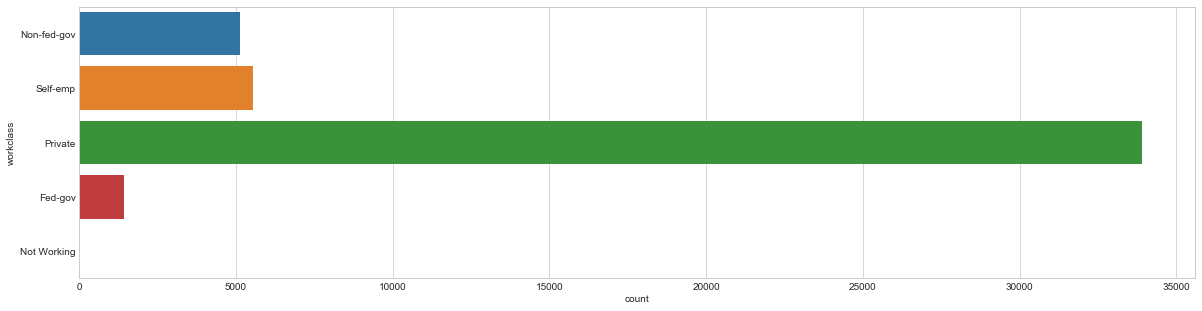

In [39]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize = (20,5))
sns.countplot(y = "workclass",data=dataset_bin)

**Occupation**

In [40]:
# plt.style.use("seaborn-whitegrid")
# plt.figure(figsize=(20,5))
# sns.countplot(y = "occupation",data=dataset_raw)
# 属性融合,此特征分布的差距并不是很大，仔细看下一个属性

**属性：Native Country**

In [41]:
# plt.style.use("seaborn-whitegrid")
# plt.figure(figsize=(20,5))
# sns.countplot(y = "native-country",data= dataset_raw);
## 该属性就需要参考workclass方法对属性进行合并

**education**

In [42]:
# plt.style.use("seaborn-whitegrid")
# plt.figure(figsize=(20,5))
# sns.countplot(y = "education",data= dataset_raw);

**Final Weight**

In [52]:
# 体重是连续性变量，需要分箱,依旧是暴力分箱
dataset_bin['fnlwgt'] = pd.cut(dataset_raw['fnlwgt'],10)
dataset_con['fnlwgt'] = dataset_raw['fnlwgt']

# plt.style.use("seaborn-whitegrid")
# plt.figure(figsize=(20,5))
# sns.countplot(y = "fnlwgt",data= dataset_bin);

**Education Number**

In [53]:
# 教育年限需要分箱,依旧是暴力分箱
dataset_bin['education-num'] = pd.cut(dataset_raw['education-num'],10)
dataset_con['education-num'] = dataset_raw['education-num']

# plt.style.use("seaborn-whitegrid")
# plt.figure(figsize=(20,5))
# sns.countplot(y = "education-num",data= dataset_bin);

**Hours per Week**

In [54]:
# 每周工作时间
dataset_bin['hours-per-week'] = pd.cut(dataset_raw['hours-per-week'],10)
dataset_con['hours-per-week'] = dataset_raw['hours-per-week']

# plt.style.use("seaborn-whitegrid")
# plt.figure(figsize=(20,5))
# plt.subplot(121)
# sns.countplot(y = "hours-per-week",data= dataset_bin);

# plt.subplot(122)
# sns.distplot(dataset_con['hours-per-week'])

**Capital Gain/Loss**

In [55]:
# 每周工作时间
dataset_bin['capital-gain'] = pd.cut(dataset_raw['capital-gain'],5)
dataset_con['capital-gain'] = dataset_raw['capital-gain']

# plt.style.use("seaborn-whitegrid")
# plt.figure(figsize=(20,5))
# plt.subplot(121)
# sns.countplot(y = "capital-gain",data= dataset_bin);

# plt.subplot(122)
# sns.distplot(dataset_con['capital-gain'])


In [56]:
dataset_bin['capital-loss'] = pd.cut(dataset_raw['capital-loss'],5)
dataset_con['capital-loss'] = dataset_raw['capital-loss']

# plt.style.use("seaborn-whitegrid")
# plt.figure(figsize=(20,5))
# plt.subplot(121)
# sns.countplot(y = "capital-loss",data= dataset_bin);

# plt.subplot(122)
# sns.distplot(dataset_con['capital-loss'])

**Race Sec Relationship**
无需处理

In [57]:
dataset_bin["race"] = dataset_con["race"] = dataset_raw["race"]
dataset_bin["sex"] = dataset_con["sex"] = dataset_raw["sex"]
dataset_bin["relationship"] = dataset_con["relationship"] = dataset_raw["relationship"]

**属性衍生** Age+Hours Per Week

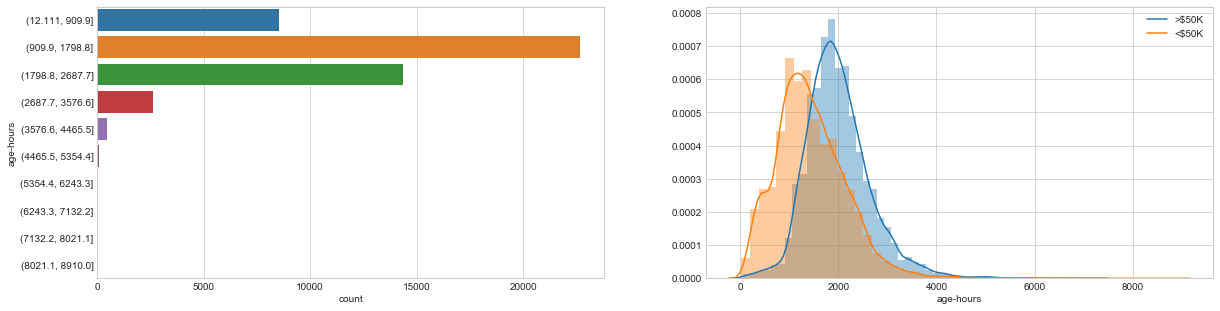

In [58]:
# 衍生
dataset_con['age-hours'] = dataset_con['age'] * dataset_con['hours-per-week']
dataset_bin['age-hours'] = pd.cut(dataset_con['age-hours'],10)
dataset_con['age-hours'] = dataset_con['age-hours']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5))
plt.subplot(121)
sns.countplot(y = "age-hours",data=dataset_bin);
plt.subplot(122)
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age-hours'],kde_kws = {"label":">$50K"})
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age-hours'],kde_kws = {"label":"<$50K"})

,predclass,age,workclass,race,sex,relationship,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,age-hours,sex-marital
0,0,"(38.9, 46.2]",Non-fed-gov,White,Male,Not-in-family,"(10806.885, 160096.5]","(11.5, 13.0]","(30.4, 40.2]","(-99.999, 19999.8]","(-4.356, 871.2]","(909.9, 1798.8]",MaleNever-married
1,0,"(46.2, 53.5]",Self-emp,White,Male,Husband,"(10806.885, 160096.5]","(11.5, 13.0]","(10.8, 20.6]","(-99.999, 19999.8]","(-4.356, 871.2]","(12.111, 909.9]",MaleMarried-civ-spouse
2,0,"(31.6, 38.9]",Private,White,Male,Not-in-family,"(160096.5, 307908.0]","(8.5, 10.0]","(30.4, 40.2]","(-99.999, 19999.8]","(-4.356, 871.2]","(909.9, 1798.8]",MaleDivorced
3,0,"(46.2, 53.5]",Private,Black,Male,Husband,"(160096.5, 307908.0]","(5.5, 7.0]","(30.4, 40.2]","(-99.999, 19999.8]","(-4.356, 871.2]","(1798.8, 2687.7]",MaleMarried-civ-spouse
4,0,"(24.3, 31.6]",Private,Black,Female,Wife,"(307908.0, 455719.5]","(11.5, 13.0]","(30.4, 40.2]","(-99.999, 19999.8]","(-4.356, 871.2]","(909.9, 1798.8]",FemaleMarried-civ-spouse


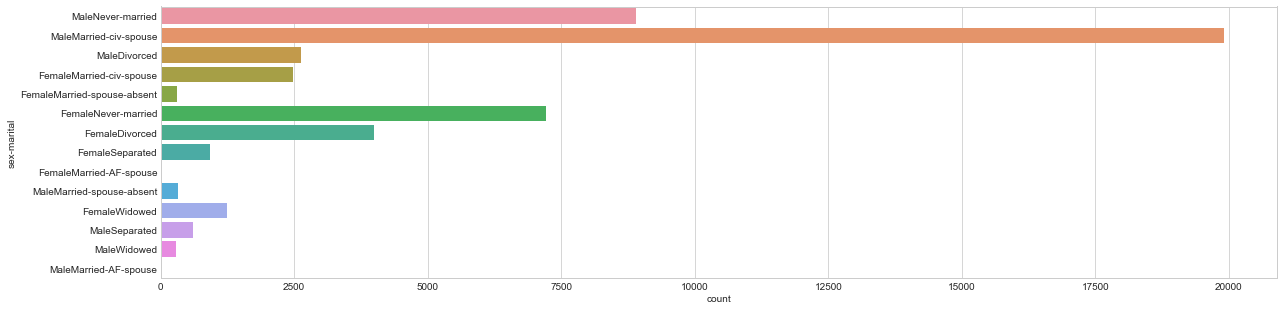

In [59]:
# 标量衍生
dataset_bin['sex-marital'] = dataset_con['sex-marital'] = dataset_raw['sex'] + dataset_raw['marital-status']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5))
sns.countplot(y = "sex-marital",data=dataset_bin);
dataset_bin.head()

In [60]:
dataset_con

,predclass,age,workclass,race,sex,relationship,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,age-hours,sex-marital
0,0,39,Non-fed-gov,White,Male,Not-in-family,77516,13,40,2174,0,1560,MaleNever-married
1,0,50,Self-emp,White,Male,Husband,83311,13,13,0,0,650,MaleMarried-civ-spouse
2,0,38,Private,White,Male,Not-in-family,215646,9,40,0,0,1520,MaleDivorced
3,0,53,Private,Black,Male,Husband,234721,7,40,0,0,2120,MaleMarried-civ-spouse
4,0,28,Private,Black,Female,Wife,338409,13,40,0,0,1120,FemaleMarried-civ-spouse
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0,39,Private,White,Female,Not-in-family,215419,13,36,0,0,1404,FemaleDivorced
48838,0,64,NaN,Black,Male,Other-relative,321403,9,40,0,0,2560,MaleWidowed
48839,0,38,Private,White,Male,Husband,374983,13,50,0,0,1900,MaleMarried-civ-spouse
48840,0,44,Private,Asian-Pac-Islander,Male,Own-child,83891,13,40,5455,0,1760,MaleDivorced


**属性编码**
把字符型变成数字型的编码  
方法：  
    one hot  
    label encoding  

两种编码适合的模型不一样，独热编码用决策树，相对还是label好一些

In [61]:
# 所有变量进行one hot编码（离散）
one_hot_cols = dataset_bin.columns.tolist()
one_hot_cols.remove("predclass")
dataset_bin_enc = pd.get_dummies(dataset_bin,columns=one_hot_cols)

dataset_bin_enc.head()

,predclass,"age_(16.927, 24.3]","age_(24.3, 31.6]","age_(31.6, 38.9]","age_(38.9, 46.2]","age_(46.2, 53.5]","age_(53.5, 60.8]","age_(60.8, 68.1]","age_(68.1, 75.4]","age_(75.4, 82.7]",...,sex-marital_FemaleNever-married,sex-marital_FemaleSeparated,sex-marital_FemaleWidowed,sex-marital_MaleDivorced,sex-marital_MaleMarried-AF-spouse,sex-marital_MaleMarried-civ-spouse,sex-marital_MaleMarried-spouse-absent,sex-marital_MaleNever-married,sex-marital_MaleSeparated,sex-marital_MaleWidowed
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# 转换为连续性数字变量
encoder = LabelEncoder()
dataset_con = dataset_con.astype(str)

dataset_con_enc = dataset_con.apply(encoder.fit_transform)

dataset_con_enc.head(20)

,predclass,age,workclass,race,sex,relationship,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,age-hours,sex-marital
0,0,22,1,4,1,1,26905,4,34,35,0,252,11
1,0,33,4,4,1,0,27243,4,4,0,0,1268,9
2,0,21,3,4,1,1,13364,15,34,0,0,237,7
3,0,36,3,2,1,0,15068,13,34,0,0,481,9
4,0,11,3,2,0,5,21239,4,34,0,0,60,2
5,0,20,3,4,0,5,18488,5,34,0,0,221,2
6,0,32,3,2,0,1,6159,11,7,0,0,1341,3
7,1,35,4,4,1,0,12747,15,39,0,0,567,9
8,1,14,3,4,0,1,24463,5,45,13,0,247,4
9,1,25,3,4,1,0,6065,4,34,96,0,302,9


### 属性降维/选择（做减法）
原因：正确，效率  
**降维：**  
    
    Principal Component Analysis（PCA）
    Singular Value Decomposition（SVD）
**选择（重要性）**
    
    过滤：过滤方法仅根据一般度量标准选择要素，例如与要预测的变量的相关性。过滤方法抑制最不感兴趣的变量，其他变量将是用于分类或者预测数据的分类或回归模型的一部分，这些方法在计算时间方面特别有效，并且对过度拟合具有鲁棒性。
    包装：包装方法评估变量子集，与过滤器方法不同，它允许检测变量之间可能的相互作用，这些方法的两个主要缺点是：1. 当观测数量不足时，过度拟合风险增加；2 变量数量很大时的显著计算时间
    嵌入式：嵌入式方法视图结合两种先前方法的优点，学习算法利用其自己的变量选择过程执行特征选择和分类。
过滤：把与最终结果相关性较小的过滤掉  

### 属性相关性
相关性衡量两个随机变量一起变化的程度。期望：属性应该彼此不相关，并且与我们视图预测的目标高度相关

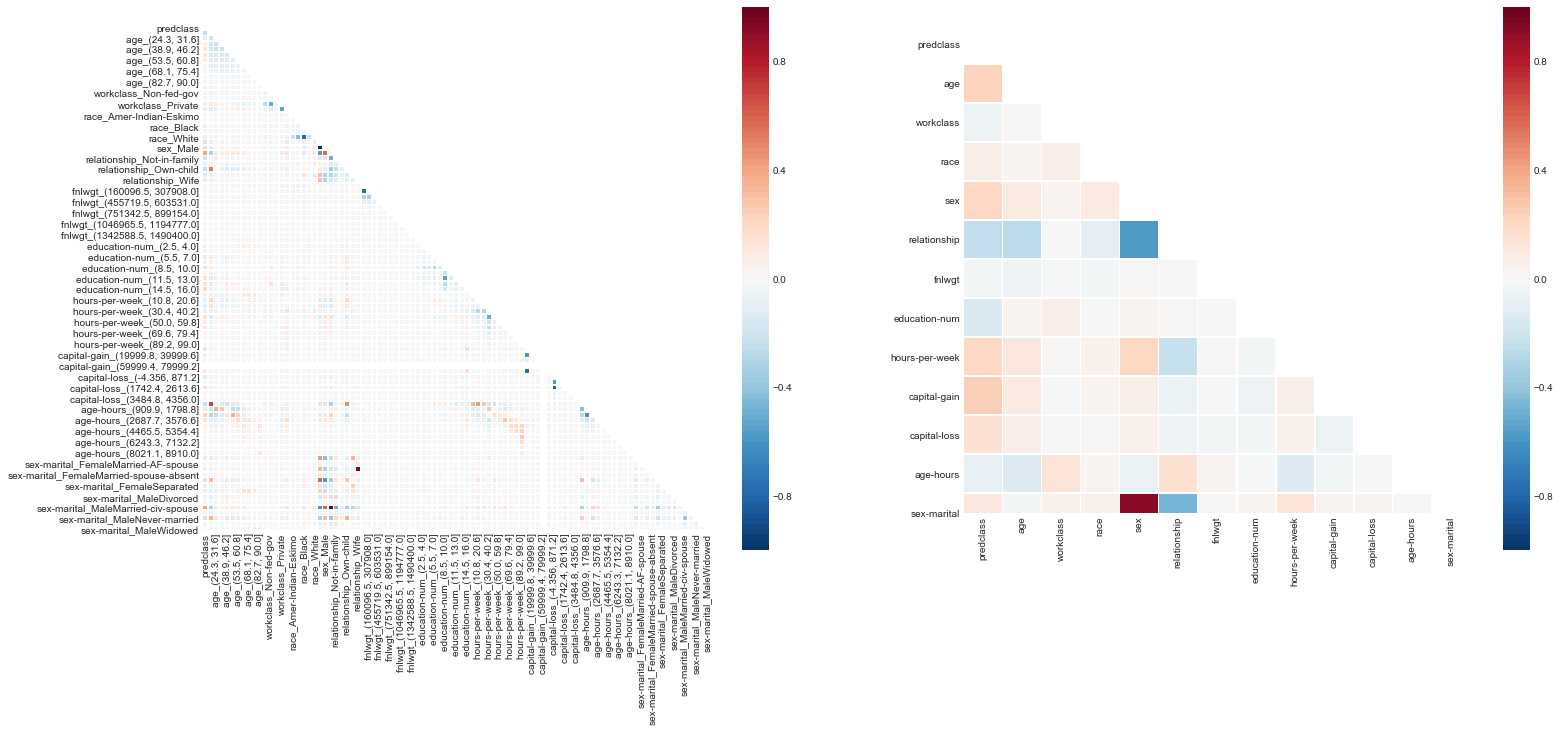

In [63]:
# 绘制两个数据集的关系图
plt.style.use("seaborn-whitegrid")
fig = plt.figure(figsize=(25,10))
plt.subplot(121)
# 关系热力图
mask = np.zeros_like(dataset_bin_enc.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_bin_enc.corr()
           ,vmin=-1
           ,vmax=1
           ,square=True
           ,cmap=sns.color_palette("RdBu_r",100)
           ,mask = mask
           ,linewidths=.5);
plt.subplot(122)
mask = np.zeros_like(dataset_con_enc.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr()
           ,vmin=-1
           ,vmax=1
           ,square=True
           ,cmap=sns.color_palette("RdBu_r",100)
           ,mask = mask
           ,linewidths=.5);

### Feature Importance
随机森林

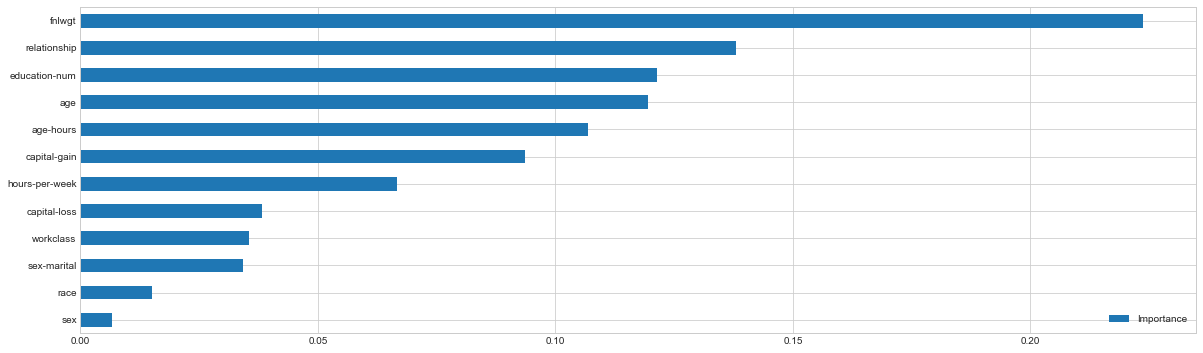

In [64]:
# 使用随机森林算法查看属性重要性,随机森林之所以很明显的能够算出相关性：是因为其每次选择都是最优属性
clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop("predclass",axis = 1),dataset_con_enc["predclass"])
plt.style.use("seaborn-whitegrid")
importance = clf.feature_importances_
importance = pd.DataFrame(importance,index=dataset_con_enc.drop('predclass',axis = 1).columns,columns=['Importance'])
importance.sort_values(by = "Importance",ascending = True).plot(kind = "barh",figsize = (20,len(importance)/2));

### PCA

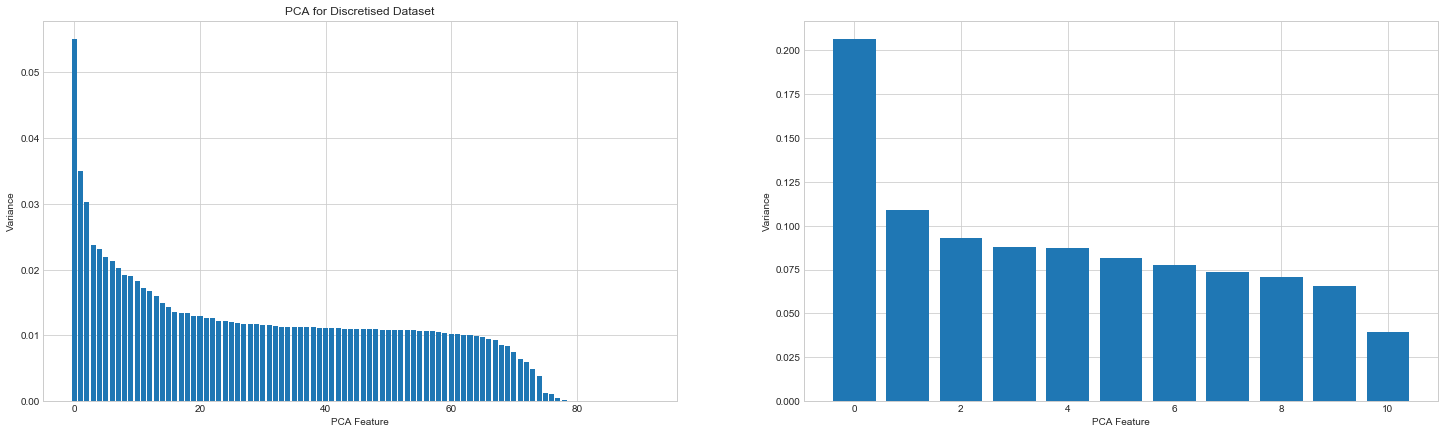

In [65]:
# 计算PCa并绘制方差
std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop("predclass",axis = 1))
X = std_scale.transform(dataset_bin_enc.drop("predclass",axis = 1))
pcal = PCA(n_components=len(dataset_bin_enc.columns)-1)
fit1 = pcal.fit(X)

std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop("predclass",axis = 1))
X = std_scale.transform(dataset_con_enc.drop("predclass",axis = 1))
pca2 = PCA(n_components=len(dataset_con_enc.columns)-2)
fit2 = pca2.fit(X)
# 绘制每个属性的方差
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(25,7))
plt.subplot(121)
plt.xlabel("PCA Feature")
plt.ylabel("Variance")
plt.title("PCA for Discretised Dataset")
plt.bar(range(0,fit1.explained_variance_ratio_.size),fit1.explained_variance_ratio_);

plt.subplot(122)
plt.xlabel("PCA Feature")
plt.ylabel("Variance")
plt.bar(range(0,fit2.explained_variance_ratio_.size),fit2.explained_variance_ratio_);

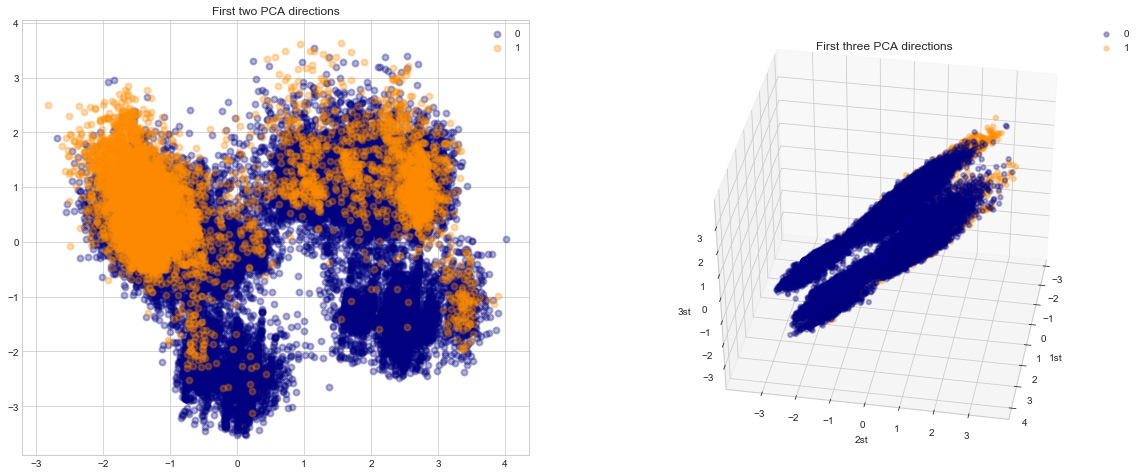

In [66]:
# PCA元素的二维三维显示
std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop("predclass",axis = 1))
X = std_scale.transform(dataset_con_enc.drop("predclass",axis = 1))
y = dataset_con_enc["predclass"]

# 格式
target_names = [0,1]
colors = ["navy","darkorange"]
lw = 2
alpha = 0.3
# 2个最优属性
plt.style.use("seaborn-whitegrid")
plt.figure(2,figsize=(20,8))
plt.subplot(121)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
for color, i ,target_name in zip(colors,[0,1],target_names):
    plt.scatter(X_r[y == i,0],X_r[y == i,1]
               ,color = color
               ,alpha = alpha
               ,lw = lw
               ,label = target_name)
plt.legend(loc = "best",shadow = False,scatterpoints = 1)
plt.title("First two PCA directions")

# 3个最优属性
ax = plt.subplot(122,projection = "3d")
X_reduced = pca.fit(X).transform(X)
for color, i ,target_name in zip(colors,[0,1],target_names):
    ax.scatter(X_reduced[y == i,0],X_reduced[y == i,1],X_reduced[y ==i ,1]
               ,color = color
               ,alpha = alpha
               ,lw = lw
               ,label = target_name)
plt.legend(loc = "best",shadow = False,scatterpoints = 1)
plt.title("First three PCA directions")
ax.set_xlabel("1st")
ax.set_ylabel("2st")
ax.set_zlabel("3st")
ax.view_init(40,10) # 三维图像旋转
# 化此图除了展现效果没别的意义

### 选择数据集
现在有两个可供选择以应用ML算法，分别是One-hot-encoded和label-encoded，不进行特征选择

In [67]:
# dataset_bin_enc
# dataset_con_enc
selected_dataset = dataset_con_enc
selected_dataset.head()

,predclass,age,workclass,race,sex,relationship,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,age-hours,sex-marital
0,0,22,1,4,1,1,26905,4,34,35,0,252,11
1,0,33,4,4,1,0,27243,4,4,0,0,1268,9
2,0,21,3,4,1,1,13364,15,34,0,0,237,7
3,0,36,3,2,1,0,15068,13,34,0,0,481,9
4,0,11,3,2,0,5,21239,4,34,0,0,60,2


In [68]:
# 拆分数据集为&训练集和测试集
# 因为前面合并了
train = selected_dataset.loc[0:32560,:]
test = selected_dataset.loc[32560:,:]
# 去除缺失值(在此仅适用于缺失值较少，若较多则填充)
train = train.dropna(axis = 0)
test = test.dropna(axis = 0)

In [69]:
# 重命名属性核目标
X_train_w_label = train
X_train = train.drop(['predclass'],axis = 1)
y_train = train['predclass'].astype('int64')

X_test = test.drop(['predclass'],axis = 1)
y_test = test['predclass'].astype('int64')

print(X_train.shape)
X_train.head()

(32561, 12)


,age,workclass,race,sex,relationship,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,age-hours,sex-marital
0,22,1,4,1,1,26905,4,34,35,0,252,11
1,33,4,4,1,0,27243,4,4,0,0,1268,9
2,21,3,4,1,1,13364,15,34,0,0,237,7
3,36,3,2,1,0,15068,13,34,0,0,481,9
4,11,3,2,0,5,21239,4,34,0,0,60,2


In [70]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: predclass, dtype: int64

In [71]:
# 设置随机种子
random.seed(1)

**选择算法**
    
    KNN
    Logistic Regression
    Random Forest
    Naive Bayes
    Stochastic Gradient Decent
    Linear SVC
    Decision Tree
    Gradient Boosted Trees

In [72]:
# 绘制ROC曲线
def plot_roc_curve(y_test,preds):
    fpr, tpr ,threshold = metrics.roc_curve(y_test,preds)
    roc_auc = metrics.auc(fpr,tpr)
    plt.title("Receiver Operating Characteristic")
    plt.plot(fpr,tpr,"b",label = "AUC = %0.2f"% roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.01,1.01])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
 

In [73]:
# 训练模型，并输出预测结果
def fit_ml_algo(algo,X_train,y_train,X_test,cv):
    model = algo.fit(X_train,y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo,(LogisticRegression
                        ,KNeighborsClassifier
                        ,GaussianNB
                        ,DecisionTreeClassifier
                        ,RandomForestClassifier
                        ,GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Availabel"
    acc = round(model.score(X_test,y_test)*100,2)
    # 交叉验证
    train_pred = model_selection.cross_val_predict(algo
                                                  ,X_train
                                                  ,y_train
                                                  ,cv = cv
                                                  ,n_jobs = -1 # 使用所有CPU核
                                                  )
    acc_cv = round(metrics.accuracy_score(y_train,train_pred)* 100,2)
    return train_pred, test_pred, acc, acc_cv , probs

In [74]:
# 逻辑回归（随机选择最优参数）
# 输出最佳参数的统一方法
def report(results,n_top = 5):
    for i in range(1,n_top+1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("MEan validation score: {0:.3f} (std:{1:.3f})".format(results['mean_test_score'][candidate]
                                                                       ,results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")
# 设置参数
param_dist = {"penalty":['l2','l1']
             ,'class_weight':[None,'balanced']
             ,"C":np.logspace(-20,20,10000)
             ,'intercept_scaling':np.logspace(-20,20,10000)}
# 随机选择参数
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc
                                  ,n_jobs=-1
                                  ,param_distributions=param_dist
                                  ,n_iter = n_iter_search)
start = time.time()
random_search.fit(X_train,y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."%((time.time() - start),n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 7.22 seconds for 10 candidates parameter settings.
Model with rank: 1
MEan validation score: 0.789 (std:0.002)
Parameters: {'penalty': 'l1', 'intercept_scaling': 600.1748986257339, 'class_weight': None, 'C': 3.59546922289169e+17}

Model with rank: 2
MEan validation score: 0.787 (std:0.001)
Parameters: {'penalty': 'l1', 'intercept_scaling': 1.660053223052646e-19, 'class_weight': None, 'C': 3523341144.9850783}

Model with rank: 3
MEan validation score: 0.787 (std:0.002)
Parameters: {'penalty': 'l1', 'intercept_scaling': 1.0004606691503662e-18, 'class_weight': None, 'C': 27.42482180431027}

Model with rank: 4
MEan validation score: 0.759 (std:0.000)
Parameters: {'penalty': 'l1', 'intercept_scaling': 3.8393563747196856e-18, 'class_weight': None, 'C': 3.5006961379758116e-19}

Model with rank: 4
MEan validation score: 0.759 (std:0.000)
Parameters: {'penalty': 'l2', 'intercept_scaling': 178412444012278.84, 'class_weight': None, 'C': 282777691361808.9}



Accuracy:78.94
Accuracy CV 10-Fold: 78.72
Running Time: 0:00:02.049559 
________________________________-----------------------------================================
              precision    recall  f1-score   support

           0       0.81      0.95      0.87     24720
           1       0.63      0.28      0.38      7841

    accuracy                           0.79     32561
   macro avg       0.72      0.61      0.63     32561
weighted avg       0.76      0.79      0.75     32561

              precision    recall  f1-score   support

           0       0.81      0.95      0.87     12435
           1       0.62      0.27      0.38      3847

    accuracy                           0.79     16282
   macro avg       0.72      0.61      0.63     16282
weighted avg       0.76      0.79      0.76     16282



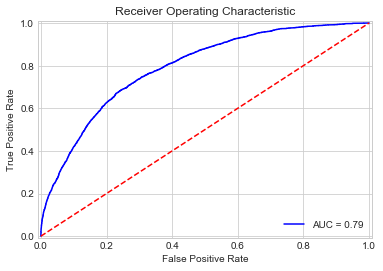

In [75]:
# 训练
start_time = time.time()
train_pred_log,test_pred_log,acc_log,acc_cv_log,probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1)
                                                                        ,X_train
                                                                        ,y_train
                                                                        ,X_test
                                                                        ,10)
log_time = (time.time() - start_time)
print("Accuracy:%s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s " % datetime.timedelta(seconds = log_time))
print("________________________________-----------------------------================================")
# 查看逻辑回归取得的成绩和所有指标
print(metrics.classification_report(y_train,train_pred_log))
print(metrics.classification_report(y_test,test_pred_log))
plot_roc_curve(y_test,probs_log)

Accuracy:73.37
Accuracy CV 10-Fold: 73.09
Running Time: 0:00:01.797104 
------------------=================---------------------====---=-=-=-
              precision    recall  f1-score   support

           0       0.80      0.87      0.83     24720
           1       0.42      0.29      0.34      7841

    accuracy                           0.73     32561
   macro avg       0.61      0.58      0.59     32561
weighted avg       0.70      0.73      0.71     32561

              precision    recall  f1-score   support

           0       0.80      0.87      0.83     12435
           1       0.41      0.29      0.34      3847

    accuracy                           0.73     16282
   macro avg       0.60      0.58      0.59     16282
weighted avg       0.71      0.73      0.72     16282



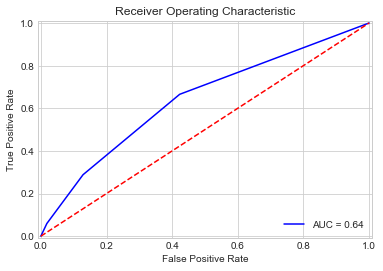

In [76]:
# KNN
start_time = time.time()
train_pred_knn,test_pred_knn,acc_knn,acc_cv_knn,probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3
                                                                                             ,n_jobs = -1)
                                                                                          ,X_train
                                                                                          ,y_train
                                                                                          ,X_test
                                                                                          ,10)
knn_time = (time.time() - start_time)
print("Accuracy:%s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s " % datetime.timedelta(seconds = knn_time))

print("------------------=================---------------------====---=-=-=-")
# 查看报告和ROC曲线
print(metrics.classification_report(y_train,train_pred_knn))
print(metrics.classification_report(y_test,test_pred_knn))
plot_roc_curve(y_test,probs_knn)

Accuracy:79.7
Accuracy CV 10-Fold: 79.67
Running Time: 0:00:00.173539 
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.93      0.87     24720
           1       0.62      0.39      0.48      7841

    accuracy                           0.80     32561
   macro avg       0.73      0.66      0.68     32561
weighted avg       0.78      0.80      0.78     32561

              precision    recall  f1-score   support

           0       0.83      0.92      0.87     12435
           1       0.61      0.38      0.47      3847

    accuracy                           0.80     16282
   macro avg       0.72      0.65      0.67     16282
weighted avg       0.78      0.80      0.78     16282



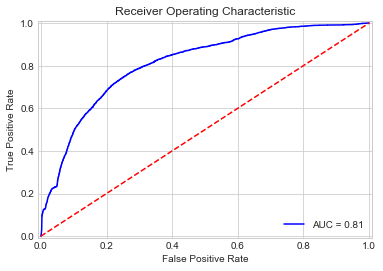

In [77]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian,test_pred_gaussian,acc_gaussian,acc_cv_gaussian,probs_gaussian = fit_ml_algo(GaussianNB()
                                                                                          ,X_train
                                                                                          ,y_train
                                                                                          ,X_test
                                                                                          ,10)
gaussian_time = (time.time() - start_time)
print("Accuracy:%s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s " % datetime.timedelta(seconds = gaussian_time))

print("------------------------------------------------------------------------")
# 查看报告和ROC曲线
print(metrics.classification_report(y_train,train_pred_gaussian))
print(metrics.classification_report(y_test,test_pred_gaussian))
plot_roc_curve(y_test,probs_gaussian)

In [78]:
# Linear SVC
start_time = time.time()
train_pred_svc,test_pred_svc,acc_linear_svc,acc_cv_linear_svc,_ = fit_ml_algo(LinearSVC()
                                                                                          ,X_train
                                                                                          ,y_train
                                                                                          ,X_test
                                                                                          ,10)
linear_svc_time = (time.time() - start_time)
print("Accuracy:%s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s " % datetime.timedelta(seconds = linear_svc_time))
print("-------------------------------------------------------------------------")
# 查看报告和ROC曲线
print(metrics.classification_report(y_train,train_pred_svc))
print(metrics.classification_report(y_test,test_pred_svc))

Accuracy:76.86
Accuracy CV 10-Fold: 63.24
Running Time: 0:00:21.904428 
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75     24720
           1       0.29      0.37      0.32      7841

    accuracy                           0.63     32561
   macro avg       0.54      0.54      0.54     32561
weighted avg       0.66      0.63      0.65     32561

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     12435
           1       0.72      0.03      0.06      3847

    accuracy                           0.77     16282
   macro avg       0.74      0.51      0.47     16282
weighted avg       0.76      0.77      0.68     16282



Accuracy:80.25
Running Time: 0:00:00.691113 
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     24720
           1       0.59      0.61      0.60      7841

    accuracy                           0.81     32561
   macro avg       0.74      0.74      0.74     32561
weighted avg       0.81      0.81      0.81     32561

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     12435
           1       0.58      0.59      0.59      3847

    accuracy                           0.80     16282
   macro avg       0.73      0.73      0.73     16282
weighted avg       0.80      0.80      0.80     16282



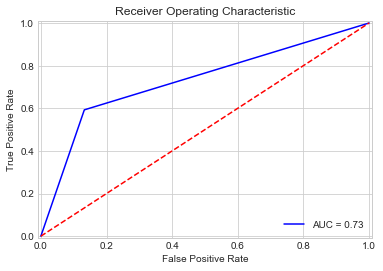

In [79]:
# 决策树
start_time = time.time()
train_pred_dt,test_pred_dt,acc_dt,acc_cv_dt,probs_dt = fit_ml_algo(DecisionTreeClassifier()
                                                                                          ,X_train
                                                                                          ,y_train
                                                                                          ,X_test
                                                                                          ,10)
dt_time = (time.time() - start_time)
print("Accuracy:%s" % acc_dt)
print("Running Time: %s " % datetime.timedelta(seconds = dt_time))
print("-------------------------------------------------------------------------")
# 查看报告和ROC曲线
print(metrics.classification_report(y_train,train_pred_dt))
print(metrics.classification_report(y_test,test_pred_dt))
plot_roc_curve(y_test,probs_dt)

In [80]:
# 随机森林
# 输出参数得分
def report(results,n_top = 5):
    for i in range(1,n_top+1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("MEan validation score: {0:.3f} (std:{1:.3f})".format(results['mean_test_score'][candidate]
                                                                       ,results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")
# 设置参数
param_dist = {"max_depth":[10,None]
             ,'max_features':sp_randint(1,11)
              ,"min_samples_split":sp_randint(2,20)
              ,"min_samples_leaf":sp_randint(1,11)
              ,"bootstrap":[True,False]
              ,"criterion":["gini","entropy"]}
# 随机搜索
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc
                                  ,n_jobs=-1
                                  ,param_distributions=param_dist
                                  ,n_iter=n_iter_search)
start_time = time.time()
random_search.fit(X_train,y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."%((time.time() - start),n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 37.80 seconds for 10 candidates parameter settings.
Model with rank: 1
MEan validation score: 0.852 (std:0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 9, 'min_samples_split': 14}

Model with rank: 2
MEan validation score: 0.852 (std:0.005)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 14}

Model with rank: 3
MEan validation score: 0.852 (std:0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 4, 'min_samples_split': 16}

Model with rank: 4
MEan validation score: 0.850 (std:0.002)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 15}

Model with rank: 5
MEan validation score: 0.850 (std:0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth':

Accuracy:85.0
Accuracy CV 10-Fold: 84.64
Running Time: 0:00:02.507326 
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     24720
           1       0.72      0.60      0.65      7841

    accuracy                           0.85     32561
   macro avg       0.80      0.76      0.78     32561
weighted avg       0.84      0.85      0.84     32561

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     12435
           1       0.73      0.59      0.65      3847

    accuracy                           0.85     16282
   macro avg       0.80      0.76      0.78     16282
weighted avg       0.84      0.85      0.84     16282



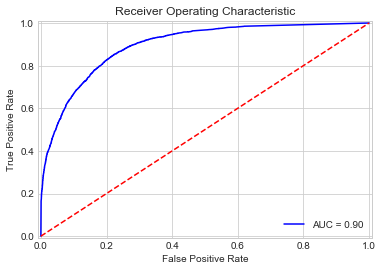

In [81]:
# 训练
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10
                            ,min_samples_leaf=2
                            ,min_samples_split=17
                            ,criterion="gini"
                            ,max_features=8)
train_pred_rf,test_pred_rf,acc_rf,acc_cv_rf,probs_rf = fit_ml_algo(rfc
                                                                  ,X_train
                                                                  ,y_train
                                                                  ,X_test
                                                                  ,10)
rf_time = (time.time() - start_time)
print("Accuracy:%s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s " % datetime.timedelta(seconds = rf_time))
print("-------------------------------------------------------------------------")
# 查看报告和ROC曲线
print(metrics.classification_report(y_train,train_pred_rf))
print(metrics.classification_report(y_test,test_pred_rf))
plot_roc_curve(y_test,probs_rf)

Accuracy:86.06
Accuracy CV 10-Fold: 85.66
Running Time: 0:00:08.690708 
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     24720
           1       0.78      0.57      0.66      7841

    accuracy                           0.86     32561
   macro avg       0.83      0.76      0.78     32561
weighted avg       0.85      0.86      0.85     32561

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     12435
           1       0.78      0.57      0.66      3847

    accuracy                           0.86     16282
   macro avg       0.83      0.76      0.79     16282
weighted avg       0.85      0.86      0.85     16282



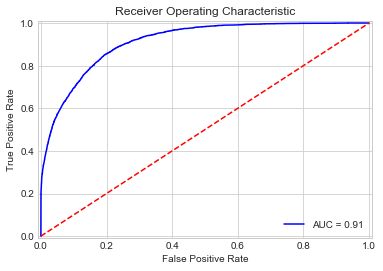

In [82]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt,test_pred_gbt,acc_gbt,acc_cv_gbt,probs_gbt = fit_ml_algo(GradientBoostingClassifier()
                                                                  ,X_train
                                                                  ,y_train
                                                                  ,X_test
                                                                  ,10)
gbt_time = (time.time() - start_time)
print("Accuracy:%s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s " % datetime.timedelta(seconds = gbt_time))
print("-------------------------------------------------------------------------")
# 查看报告和ROC曲线
print(metrics.classification_report(y_train,train_pred_gbt))
print(metrics.classification_report(y_test,test_pred_gbt))
plot_roc_curve(y_test,probs_gbt)

### 效果对比

In [83]:
models = pd.DataFrame({
    'Model':['KNN','Logistic Regression','Random Forest','Naive Bayes','Linear SVC','Decision Tree','Gradient Boosting Trees']
    ,'Score':[acc_knn
             ,acc_log
             ,acc_rf
             ,acc_gaussian
             ,acc_linear_svc
             ,acc_dt
             ,acc_gbt]
})

models.sort_values(by = 'Score',ascending = False)

,Model,Score
6,Gradient Boosting Trees,86.06
2,Random Forest,85.00
5,Decision Tree,80.25
3,Naive Bayes,79.70
1,Logistic Regression,78.94
4,Linear SVC,76.86
0,KNN,73.37


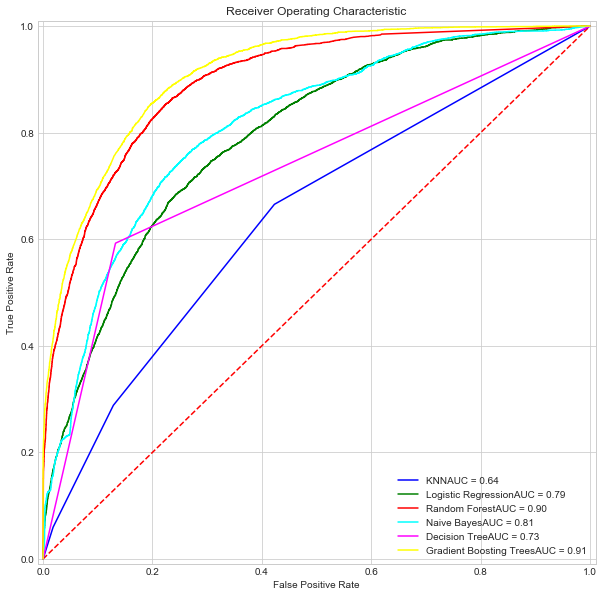

In [84]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure(figsize=(10,10))

models = ['KNN','Logistic Regression','Random Forest','Naive Bayes','Decision Tree','Gradient Boosting Trees']
probs = [probs_knn,probs_log,probs_rf,probs_gaussian,probs_dt,probs_gbt]
colors = ['blue','green','red','cyan','magenta','yellow']

plt.title("Receiver Operating Characteristic")
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

def plot_roc_curves(y_test,prob,model):
    fpr,tpr,threshold = metrics.roc_curve(y_test,prob)
    roc_auc = metrics.auc(fpr,tpr)
    plt.plot(fpr,tpr,'b',label = model + 'AUC = %0.2f'% roc_auc,color = colors[i])
    plt.legend(loc = 'lower right')

for i ,model in list(enumerate(models)):
    plot_roc_curves(y_test,probs[i],models[i])
plt.show()